프로젝트 : 모든 장르 간 편향성 측정해 보기
===

영화 시놉시스 코퍼스를 가지고 영화 구분과 모든 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보겠습니다. 
    

- WEAT(Word Embedding Association Test)       
    워드 임베딩에 내포된 편향성을 정량적으로 측정하는 방법    
    논문 : https://arxiv.org/pdf/1608.07187.pdf
    
    
[ 목차 ]
1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. target, attribute 단어 셋 만들기
4. WEAT score 계산과 시각화

## 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
     
synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있습니다. (개봉된 영화 중 일부만 포함되어있습니다. 더 많은 영화 정보는 KOBIS에서 확인 가능합니다.) synopsis.txt의 일부를 읽어봅니다.

In [1]:
import os

with open(os.getenv('HOME')+'/aiffel/GoingDeeper/nlp6/data/synopsis.txt', 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


이제 synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장해봅니다. konlpy 패키지를 이용해봅니다.

In [2]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/GoingDeeper/nlp6/data/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:     # "Adjective", "Verb" 등을 포함할 수도 있습니다
                res.append(w[0])     # 명사("Noun")일 때만 tokenized 에 저장
        tokenized.append(res)

- class konlpy.tag.\_okt.Okt     
    okt.pos() : Part of Speech, POS (품사) tagger    
    - stem=True : stem tokens
    - norm=True : normalize tokens    
    https://konlpy.org/en/latest/api/konlpy.tag/#okt-class

In [3]:
print(len(tokenized))

71156


# 2. 추출된 결과로 embedding model 만들기


In [4]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 Word2Vec을 생성 (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[('작품', 0.8873289227485657),
 ('다큐멘터리', 0.8450316190719604),
 ('드라마', 0.8140425086021423),
 ('영화로', 0.8049192428588867),
 ('설정', 0.786869466304779),
 ('형식', 0.7782349586486816),
 ('코미디', 0.7765371799468994),
 ('스토리', 0.7690247893333435),
 ('감동', 0.7674833536148071),
 ('모티브', 0.7670546174049377)]

- Word2Vec()    
    vector size : 학습 후 임베딩 벡터의 차원     
    window : 컨텍스트 윈도우 크기     
    min_count : 단어 최소 빈도수 제한     
    sg : 0은 CBoW, 1은 Skip-gram    
    https://radimrehurek.com/gensim/models/word2vec.html

In [5]:
model.wv.most_similar(positive=['사랑'])

[('정일', 0.7549949884414673),
 ('애정', 0.7251827120780945),
 ('만남', 0.7046142220497131),
 ('첫사랑', 0.7043058276176453),
 ('행복', 0.6887596249580383),
 ('진심', 0.6808720827102661),
 ('나비문신', 0.6771438121795654),
 ('비랄', 0.6725327968597412),
 ('가슴', 0.6718639731407166),
 ('우정', 0.6680269241333008)]

In [6]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9056504964828491),
 ('영화감독', 0.9031640291213989),
 ('영감', 0.8886488676071167),
 ('대본', 0.8882438540458679),
 ('배우', 0.8837581276893616),
 ('데뷔', 0.8724600076675415),
 ('캐스팅', 0.8578909635543823),
 ('출연', 0.8575723767280579),
 ('팬', 0.8560932874679565),
 ('예술가', 0.8551438450813293)]

- Word2Vec가 잘 훈련된 것을 볼 수 있습니다. 

# 3. target, attribute 단어 셋 만들기

TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋을 만들어 보겠습니다.    
WEAT score를 구할 때 단어 셋을 만들어주어야 합니다. 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 합니다.
     
여기서는 두 축을 영화 장르, 영화 구분 정보를 이용하겠습니다. (영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보입니다. KOBIS에서 제공한 정보를 기준으로 분류하였습니다.)

- 영화 구분    
    synopsis_art.txt : 예술영화, synopsis_gen.txt : 일반영화(상업영화), 그 외는 독립영화 등으로 분류됩니다.
- 장르 구분    
    synopsis_SF.txt: SF, synopsis_family.txt: 가족, synopsis_show.txt: 공연, synopsis_horror.txt: 공포(호러), synopsis_etc.txt: 기타, synopsis_documentary.txt: 다큐멘터리, synopsis_drama.txt: 드라마, synopsis_romance.txt: 멜로로맨스, synopsis_musical.txt: 뮤지컬, synopsis_mystery.txt: 미스터리, synopsis_crime.txt: 범죄, synopsis_historical.txt: 사극, synopsis_western.txt: 서부극(웨스턴), synopsis_adult.txt: 성인물(에로), synopsis_thriller.txt: 스릴러, synopsis_animation.txt: 애니메이션, synopsis_action.txt: 액션, synopsis_adventure.txt: 어드벤처, synopsis_war.txt: 전쟁, synopsis_comedy.txt: 코미디, synopsis_fantasy.txt: 판타지
    
예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠습니다.    
ex) 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 봅니다.
    

## target 단어 셋 만들기 

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 명사에 대해서만 추출하여 art, gen 변수에 할당합니다.

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [8]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/GoingDeeper/nlp6/data/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [9]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요합니다.     
ex) 예술영화라는 개념을 가장 잘 대표하는 단어들을 art_txt를 처리해서 만든 art라는 단어 리스트에서 골라냅니다.    
    
이를 위해서 상식을 동원해서 적절한 단어를 골라낼 수도 있지만 보다 납득할 수 있는 보편적인 방법을 사용하는 것이 좋습니다.
예술영화, 일반영화라는 영화 구분별로 시놉시스를 모아 데이터를 구성했습니다. 그렇다면 예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당합니다.
   
이런 것과 비슷한 개념의 단어 분석 방식 중, TF-IDF 방식을 사용해 봅니다.    
코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정합니다. 

- TF-IDF : https://ko.wikipedia.org/wiki/Tf-idf

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


- sklearn.feature_extraction.text.TfidfVectorizer : Convert a collection of raw documents to a matrix of TF-IDF features     
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- .fit_transform(raw_documents) : Learn vocabulary and idf, return document-term matrix
- vocabulary_ : (attribute) dict, A mapping of terms to feature indices.
- .get_feature_names() : Array mapping from feature integer indices to feature name

In [11]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [12]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져오기 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져오기 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   # art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬 
w2.sort(key=lambda x: x[1], reverse=True)   # gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬

In [13]:
print(m1)

  (0, 24288)	0.0001813433827312183
  (0, 30456)	0.0001813433827312183
  (0, 11824)	0.00025487179701503193
  (0, 20957)	0.00025487179701503193
  (0, 23539)	0.0001813433827312183
  (0, 15055)	0.0005440301481936549
  (0, 22947)	0.00025487179701503193
  (0, 19974)	0.0001813433827312183
  (0, 22314)	0.0001813433827312183
  (0, 36911)	0.0005097435940300639
  (0, 36545)	0.0001813433827312183
  (0, 16222)	0.00025487179701503193
  (0, 870)	0.0001813433827312183
  (0, 10861)	0.0001813433827312183
  (0, 22324)	0.0001813433827312183
  (0, 5551)	0.0001813433827312183
  (0, 14795)	0.0001813433827312183
  (0, 17245)	0.0001813433827312183
  (0, 7774)	0.0001813433827312183
  (0, 36535)	0.00025487179701503193
  (0, 6081)	0.0001813433827312183
  (0, 17587)	0.0001813433827312183
  (0, 33441)	0.0001813433827312183
  (0, 23952)	0.0001813433827312183
  (0, 3794)	0.0007646153910450958
  :	:
  (0, 5484)	0.0023574639755058377
  (0, 30736)	0.03717539345989975
  (0, 37858)	0.00743507869197995
  (0, 32086)	0.00036

- scipy.sparse.csc_matrix.tocoo() : Return a COOrdinate representation of this matrix    
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csc_matrix.tocoo.html

In [15]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

- 두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있습니다.     

두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 단어가 서로 중복되지 않게 단어셋을 추출해야 합니다. 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출합니다.

In [16]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어 15개 추출
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어 15개 추출
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

추출된 단어를 살펴봅니다. 

In [17]:
print('예술영화를 대표하는 단어들: ', target_art)
print('일반영화를 대표하는 단어들: ', target_gen)

예술영화를 대표하는 단어들:  ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
일반영화를 대표하는 단어들:  ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


## attribute단어 셋 만들기

여러 장르의 파일을 읽고, 명사에 대해서만 추출하여 봅니다. 

In [18]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [19]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [21]:
m = [X[i].tocoo() for i in range(X.shape[0])] # TF-IDF로 표현한 sparse matrix를 가져오기

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)): # 구성하는 단어들을 TF-IDF가 높은 순으로 정렬
    w[i].sort(key=lambda x: x[1], reverse=True)

In [22]:
# 상위 15개 까지만 추출된 단어를 살펴봅니다.
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

- 각 장르를 대표하는 단어들을 추출해보았습니다. 중복된 것이 종종 있지만 art, gen 두 개의 단어 셋을 추출했을 때에 비해 적습니다. 그러므로 중복을 체크해서 삭제하기보다 그대로 사용합니다.

# 4. WEAT score 계산과 시각화

영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅니다. 

## WEAT score 계산
    
WEAT score는 다음과 같이 정의합니다.
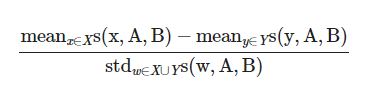

- 이 테스트는 두 벡터의 유사도를 측정하기 위해 cosine similarity를 이용합니다. cosine similarity는 두 벡터 사이의 cosine 값을 이용하여 두 벡터의 유사도를 측정합니다. 다시 말해, 두 벡터 i,j가 주어졌을 때, cosine similarity cos(θ)는 dot product와 magnitude를 사용하여 구할 수 있습니다. cosine similarity는 -1에서 1을 가질 수 있으며 두 벡터의 방향이 얼마나 유사한지를 나타내게 됩니다.
- s(w,A,B)가 의미하는 것은 target에 있는 단어 w가 두 attribute 셋 A, B에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지를 측정합니다. 즉, s(w,A,B)는 개별 단어 w가 개념축 A-B에 대해 가지는 편향성을 계산한 값이 됩니다. 이 편향성 값은 -2에서 2사이의 값을 가지게 되며, 그 절댓값이 클수록 w는 A-B 개념축에 대해 편향성을 가진다는 뜻이 됩니다.
- 분자 부분은 target X, Y에 속하는 각 단어 x, y들이 개념축 A-B에 대해 가지는 편향성을 r각각 평균 내서 뺀 차이입니다. 즉, X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가 뚜렷이 차이 날수록 이 WEAT score 식의 분자값의 절댓값은 커지게 됩니다. 이 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준편차(std)로 normalize한 값이 최종 WEAT score가 됩니다.

In [23]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [24]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [25]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

이제 WEAT_score를 구해봅니다.
     
target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해봅니다. 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅니다.

In [26]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print(len(matrix))

21


In [27]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

- matrix를 채워보았습니다. WEAT score 값을 보고, 편향성을 살펴봅니다. 

In [28]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j], matrix[i][j])

SF 가족 -0.54946536
SF 공연 -0.4137606
SF 공포(호러) -0.68496734
SF 기타 0.34931612
SF 다큐멘터리 0.5797575
SF 드라마 -0.41245207
SF 멜로로맨스 -0.7853616
SF 뮤지컬 0.3318262
SF 미스터리 -0.70302033
SF 범죄 -0.26240703
SF 사극 -0.84965473
SF 서부극(웨스턴) -0.44707945
SF 성인물(에로) -0.5605805
SF 스릴러 -0.54412216
SF 애니메이션 0.35076717
SF 액션 -0.47827128
SF 어드벤처 -0.85931325
SF 전쟁 0.25991127
SF 코미디 -0.46269828
SF 판타지 -0.20738283
가족 공연 0.17407352
가족 공포(호러) -0.14233069
가족 기타 0.7700987
가족 다큐멘터리 0.82541776
가족 드라마 0.2177932
가족 멜로로맨스 -0.6053762
가족 뮤지컬 0.716329
가족 미스터리 -0.3088354
가족 범죄 0.20198666
가족 사극 -0.052310918
가족 서부극(웨스턴) 0.44416454
가족 성인물(에로) -0.28859618
가족 스릴러 -0.1427735
가족 애니메이션 0.86765283
가족 액션 0.11752534
가족 어드벤처 -0.052102786
가족 전쟁 0.68803084
가족 코미디 0.23793964
가족 판타지 0.45323488
공연 공포(호러) -0.2224388
공연 기타 0.9424972
공연 다큐멘터리 0.91045225
공연 드라마 0.02961111
공연 멜로로맨스 -0.688334
공연 뮤지컬 0.8868338
공연 미스터리 -0.35109773
공연 범죄 0.08268581
공연 사극 -0.30295044
공연 서부극(웨스턴) 0.08401138
공연 성인물(에로) -0.44196427
공연 스릴러 -0.21300694
공연 애니메이션 0.88922465
공연 액션 -0

In [46]:
over8 = []
under_8 = []

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] >= 0.8 : 
            over8.append([i, j, matrix[i][j]])
        if matrix[i][j] <= -0.8 : 
            under_8.append([i, j, matrix[i][j]])

print("[  Over 0.8 : ", len(over8), "  ]")
for i, j, score in over8:
    print(genre_name[i], genre_name[j], score)
print()
print("[  Under -0.8 : ", len(under_8), "  ]")
for i, j, score in under_8:
    print(genre_name[i], genre_name[j], score)

[  Over 0.8 :  18   ]
가족 다큐멘터리 0.82541776
가족 애니메이션 0.86765283
공연 기타 0.9424972
공연 다큐멘터리 0.91045225
공연 뮤지컬 0.8868338
공연 애니메이션 0.88922465
드라마 뮤지컬 0.8344613
드라마 애니메이션 0.86374664
멜로로맨스 뮤지컬 0.8533098
멜로로맨스 범죄 0.82353246
멜로로맨스 성인물(에로) 0.85689807
멜로로맨스 애니메이션 0.8552071
멜로로맨스 코미디 0.8820148
멜로로맨스 판타지 0.8095987
미스터리 범죄 1.0038538
사극 애니메이션 0.8108525
사극 전쟁 0.90576726
어드벤처 판타지 0.80265284

[  Under -0.8 :  17   ]
SF 사극 -0.84965473
SF 어드벤처 -0.85931325
기타 드라마 -0.90090156
기타 멜로로맨스 -0.8846364
기타 사극 -0.8235849
기타 어드벤처 -0.84445465
다큐멘터리 드라마 -0.90746176
다큐멘터리 멜로로맨스 -0.88196063
다큐멘터리 사극 -0.89003706
다큐멘터리 성인물(에로) -0.8058696
다큐멘터리 어드벤처 -0.95450836
다큐멘터리 코미디 -0.8101738
다큐멘터리 판타지 -0.8875737
드라마 멜로로맨스 -0.81457067
뮤지컬 어드벤처 -0.8096606
범죄 스릴러 -0.9470579
애니메이션 어드벤처 -0.9095977


- WEAT score를 보고 예술영화, 일반영화와 각 장르(A, B) 간의 관계를 볼 수 있습니다.      
    WEAT score가 0.8 이상인 경우 : A장르는 예술영화, B장르는 일반영화와 가깝다    
    WEAT score가 -0.8 이하인 경우 : A장르는 일반영화, B장르는 예술영화와 가깝다 (사람의 편향과는 반대) 

## WEAT score 시각화

앞에서 계산한 WEAT score를 Heatmap으로 시각화해 봅니다. 

<AxesSubplot:>

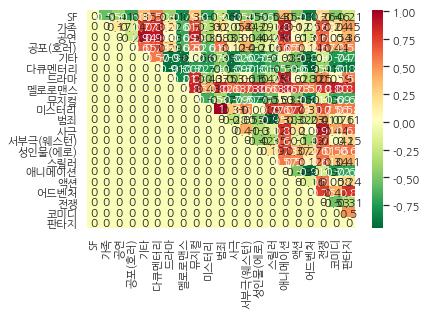

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

- seaborn.heatmap(data, xticklabels, yticklabels, annot, cmap)     
    data : rectangular dataset    
    xticklabels, yticklabels : list-like, plot these alternate labels as the xticklabels    
    annot=True : write the data value in each cell     
    cmap : The mapping from data values to color space    
    https://seaborn.pydata.org/generated/seaborn.heatmap.html     
    
WEAT score가 0.8 이상이거나 -0.8 이하인 관계만 따로 시각화 해봅니다. 

In [39]:
matrix2 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [40]:
for i, j, score in over8:
    matrix2[i][j] = score
    
for i, j, score in under_8:
    matrix2[i][j] = score

<AxesSubplot:>

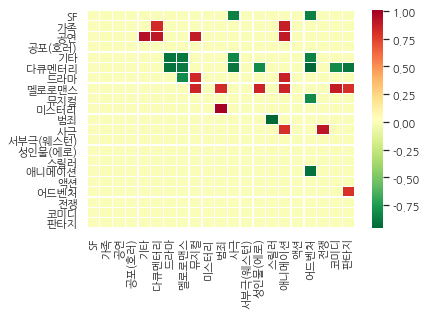

In [45]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix2, xticklabels=genre_name, yticklabels=genre_name, linewidth=0.3, cmap='RdYlGn_r')
ax

# 회고

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
    - synopsis.txt(영화들의 시놉시스 정보)의 명사인 경우만 코퍼스로 저장하였다. 
    - 위의 코퍼스 데이터를 가지고 Word2Vec을 생성하였다. 
    - 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나온것을 확인하였다.  


2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다. 
    - TF-IDF를 사용하여 높은 순으로 해당 데이터를 가장 잘 표현하는 단어 셋을 만들었다. 
    - target의 단어 셋의 중복을 제거하여 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
    - attribute의 단어 셋은 중복이 많이 겹치지 않으므로 중복을 제거하지 않고 그대로 사용하였다.


3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
    - 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score를 계산하였다.      
        WEAT score가 가장 큰 장르는 미스터리-범죄 (1.0038538)이고,    
        WEAT score가 가장 작은 장르는 범죄-스릴러 (-0.9470579)였다.     
    - WEAT score를 Heatmap으로 잘 시각화하였다.